# Neural Network that solves the Heat Equation
 The objective of this notebook is to create a NN that solves the heat equation with a certain initial value and boundary conditions in an interval $[-1,1]$ for a time interval $[0,T]$.

 * Define the network class with a loss function that solves the heat equation. leave room for initial condition and boundary condition loss terms?
 * Write functions that train and validate the network.
 * Write functions that plot the solution and the loss over the pochs
 * Define the training data in the domain.
 * Instantiate and train a baseline network. Validate it.
 * cross val with different architectures

In [1]:
# Torch imports
import torch

import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn # Neural networks
import torch.optim as optiom # Optimizer, gradient descen adam, etc.

# Other Imports
import numpy as np 
import matplotlib.pyplot as plt


## Problem definition
We want to solve the heat equation in an interval of $\mathbb{R}$
$$u_t(x,t) = u_{xx}(x,t) \qquad (x,t) \in [-1,1]\times [0,4]$$
$$u(x,0) = u_0(x) \qquad\forall x\in [-1,1]  $$
and a certain boundary condition.

We proprose a Physics Informed Neural Network $\psi_{NN}(x,t)$ and a loss function composed of 4 terms.

* $L_1 = ||\psi_{NN}(x,0)  - u_0 (x) ||_2$
* $L_2 = ||\psi_{NN}(-1,t)  - 0||_2$
* $L_3 = ||\psi_{NN}(1,t)  - 0||_2$
* $L_4 = ||\psi_{NN}(x,t)_t - \psi_{NN}(x,t)_{xx}||_2$

So our Loss function will be
$$L(\psi) := L_1(\psi) + L_2(\psi) + L_3(\psi) + L_4(\psi)$$

Of course since we can't compute exactly these $L^2$ norms, we will aproximate them with sums over some points of the domain

* $L_1 = \frac{1}{n_1}  \sum_{k=1}^{n_1} | \psi_{NN}(x_k,0)  - u_0 (x_k)|^2 $
* $L_2 = \frac{1}{n_2}  \sum_{k=1}^{n_2} | \psi_{NN}(-1,t_k) |^2 $
* $L_2 = \frac{1}{n_3}  \sum_{k=1}^{n_3} | \psi_{NN}(1,t_k) |^2 $
* $L_4 = \frac{1}{N_4}  \sum_{i=1}^{n_4} | \psi_{NN,t}((x,t)_i) - \psi_{NN,xx} ((x,t)_i) |^2 $

For some data points
* $\{x_k \}_{k=1}^{n_1}$ is a partition of $[-1,1]$. We may choose it randomly or just take a grid with a fixed step.
* Same for $\{t_k \}_{k=1}^{n_2}$ in $[0,T]$
* $\{(x,t)_i \}_{i=1}^{n_4}$ are the collocation points inside the domain that we choose randomly



## Data

We will create all of the points we will need, including a small validation data set

In [2]:
# We define our domain as $[-1,1] x [0,4]$
xm = -1
xM = 1
t0 = 0 # t siempre empieza en cero
T = 4

number_of_points = 1000

# (X, T)

#Initial condition
x_init_train = torch.linspace(xm,xM,number_of_points)
y_init_train = np.exp(-x_init_train**2 )- 1/np.e

# Reshape x
x_init_train = torch.reshape(x_init_train, (number_of_points, 1))
t_zeros = torch.zeros(number_of_points)
t_zeros = torch.reshape(t_zeros, (number_of_points,1))
x_init_train = torch.cat((x_init_train,t_zeros),dim = 1)

# Reshape y
y_init_train = torch.reshape(y_init_train, (number_of_points,1))

#Boundary condition
t_bc= torch.linspace(t0,T,number_of_points)
t_bc = torch.reshape(t_bc, (number_of_points,1))

x_bc = torch.ones(number_of_points)
x_bc = torch.reshape(x_bc,(number_of_points,1))

t_bc1_train = torch.cat((-1*x_bc,t_bc), dim = 1)
t_bc2_train = torch.cat((x_bc, t_bc), dim = 1)

y_bc1_train = torch.ones((t_bc1_train.shape[0],1))
y_bc2_train = torch.ones((t_bc2_train.shape[0],1))

t_bc_train = torch.cat((t_bc1_train, t_bc2_train), dim = 0)
y_bc_train = torch.cat((y_bc1_train, y_bc2_train), dim = 0)



In [3]:
# Colocation points
number_of_points = 10000

x_coloc_train = xm + (xM-xm)*torch.rand(number_of_points)
t_coloc_train = T*torch.rand(number_of_points)

x_coloc_train = torch.reshape(x_coloc_train,(number_of_points,1))
t_coloc_train = torch.reshape(t_coloc_train,(number_of_points,1))

X_coloc_train = torch.cat((x_coloc_train,t_coloc_train), dim = 1)
#X_coloc_train[0:10], X_coloc_train.shape


Tengo mis cuatro conjuntos de puntos para evaluar la loss

* x_init_train
* y_init_train
* t_bc1_train
* t_bc2_train
* X_coloc_train

OJO CON `t_bc_train` !!!!

No hize los vectores de ceros como los y de la boundary ocnidtion, pero ese total lo puedo ahcer despues

Me gustaria funcionalizar la manera como hago estos puntos.


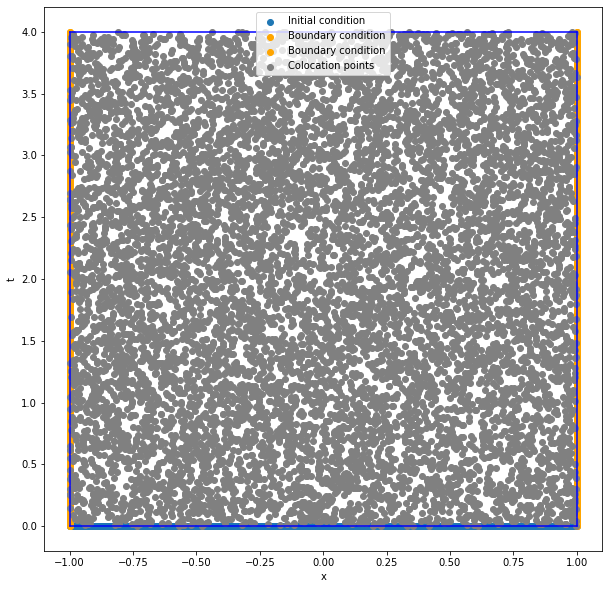

In [4]:
# Graficamos los puntos
fig, ax = plt.subplots(figsize = (10,10))

ax.set_xlabel("x")
ax.set_ylabel("t")

# Plot the domain
ax.plot([xm,xM],[0,0], color = 'blue')
ax.plot([xm,xm],[0,T], color = 'blue')
ax.plot([xM,xM],[0,T], color = 'blue')
ax.plot([xm,xM],[T,T], color = 'blue')

#plot ic
plt.scatter(x_init_train[:,0], x_init_train[:,1], label = "Initial condition")

#plot bc
plt.scatter(t_bc1_train[:,0], t_bc1_train[:,1], label = "Boundary condition", color = "orange")
plt.scatter(t_bc2_train[:,0], t_bc2_train[:,1], label = "Boundary condition", color = "orange")

# Plot Collocation points
plt.scatter(X_coloc_train[:,0], X_coloc_train[:,1], label = "Colocation points", color = "gray")

ax.legend()

## Instantiating
We have the data and we have created our pinn class. Let's instantiate it along with an optimizer and get everything ready for training.




In [7]:
from pinn import PINN

layers = [2,10,10,1]

fnn = PINN(layers)


# Optimizer
lr = 1e-3
optimizer = torch.optim.SGD(fnn.parameters(), lr = lr)


## Training


In [8]:
%%time

torch.manual_seed(42)

epochs = 1000
number_of_batches = 10

n_ic = len(x_init_train)
n_bc = len(t_bc_train) #Atencion. Esto lo estoy atando con alambras porque estoy uniendo toda al bc junto
n_coloc = len(x_coloc_train)

batch_size_ic = int(n_ic/number_of_batches)
batch_size_bc = int(n_bc/number_of_batches)
batch_size_coloc = int(n_coloc/number_of_batches)

epoch_number = []
epoch_loss = []


for ep in range(epochs):
    if ep%(epochs/10) == 0:
        print("entre")
    #Randomize the indexes to construct the batches
    indexes_ic = torch.randperm(n_ic)
    indexes_bc = torch.randperm(n_bc)
    indexes_coloc = torch.randperm(n_coloc)

    for k in range(number_of_batches):
        batch_index_ic = indexes_ic[k * batch_size_ic : (k+1)*batch_size_ic]
        batch_index_bc = indexes_bc[k * batch_size_bc : (k+1) * batch_size_bc]
        batch_index_coloc = indexes_coloc[k * batch_size_coloc : (k+1) * batch_size_coloc]

        # Entreno 
        # #ciclo clasico de pytorch.
        
        # Reset gradients to zero
        optimizer.zero_grad()

        # Prepare data
        X_init_batch = x_init_train[batch_index_ic]
        y_init_batch = y_init_train[batch_index_ic]

        X_bc_batch = t_bc_train[batch_index_bc]
        y_bc_batch = y_bc_train[batch_index_bc]        
        
        X_coloc_batch = X_coloc_train[batch_index_coloc]

        # Evaluate loss function on batch data
        loss = fnn.loss(X_ic = X_init_batch, 
                        y_ic = y_init_batch, 
                        X_bc = X_bc_batch, 
                        y_bc = y_bc_batch, 
                        X_coloc = X_coloc_batch)

        # Calculate gradients and update parameters.
        loss.backward()
        
        optimizer.step()

    #anoto la loss para graficar #onedb para logear
    if ep%(epochs/100) == 0:
        epoch_loss.append(loss)
        epoch_number.append(ep)
    if ep%(epochs/10) == 0:
        print(ep, loss)
        #entreno

entre
0 tensor(0.5755, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

## Plotting

(torch.Size([2, 2]), 2)

## Res

# Por hacer
* hacer una clase dataset que haga el dominio y lo pase al shape correcto y haga tambien un validation set. Que inlcuya un metodo para graficar, igual qeu el chabon del sciann
* Escribir la calse pinn. Hecho. Reescribirla dejando dejando lugar para la loss. La idea seria que haga una subclasse tipo el sciann que le pase la loss y se encargue tambien del training


possible improvements:
* change activation function from Tanh to relu or something else. Should run experiments.
* Is there an activation function that is already what people use for pinns?
* How to escalte each term of the loss function? Watch the video of the dr from the uk again.

## Dudas
Acá tengo dudas
* Por lo que estoy entendiendo, el autograd.grad está pensado para que lo uses con inputs y outputs escalares. Es decir, le pasas una f(x) que toma x escalar y devuelve f escalar y te calcula la derivada de f con respecto a x.
    
    Entonces, para que yo le pase mi vector X de inputs y mi vector F de outputs y todo funcione, le tengo que poner el grad_outputs como un vector de ONES para que me haga la multiplicacion de vectores y me de el output que me sirve

    Como seria la manera de trabajar? Asi como estoy haciendo? Hay una manera de programar los datos de input y la loss para que cuando escriba la linea del autograd me tome onda un escalar? Vale la pena? Como se hace? Ampliaremos.

In [92]:
# pruebas
import torch
import torch.autograd as autograd

x = torch.linspace(0,10,11)
t = torch.linspace(10,20,11)


x = torch.reshape(x, (11,1))
t = torch.reshape(t, (11,1))

xt = torch.cat([x,t], dim = 1)
print(xt[:,1])

x.requires_grad = True
t.requires_grad=True

xt.requires_grad = True
print(xt.shape)
y = x.clone()
y = xt * torch.ones((11,2))
print(y)

yt = autograd.grad(y,t)#, torch.ones(11,1), retain_graph=True)
print(yt )
ytt = autograd.grad(yt,t, torch.ones(y.shape), retain_graph=True)

tensor([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])
torch.Size([11, 2])
tensor([[ 0., 10.],
        [ 1., 11.],
        [ 2., 12.],
        [ 3., 13.],
        [ 4., 14.],
        [ 5., 15.],
        [ 6., 16.],
        [ 7., 17.],
        [ 8., 18.],
        [ 9., 19.],
        [10., 20.]], grad_fn=<MulBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [145]:
# Define f
f1 = torch.nn.Linear(2,2)
f2 = torch.nn.Linear(2,1)
def f(x):
    return f2(torch.tanh(f1(x)))
    #return f2(f1(x))

torch.manual_seed(42)
# Define data
x = torch.linspace(0,10,11)
t = torch.linspace(10,20,11)

x = torch.reshape(x, (11,1))
t = torch.reshape(t, (11,1))

xt = torch.cat([x,t], dim = 1)

print(torch.__version__)
# Define g clone evaluate and differentiate
g = xt.clone()

g.requires_grad=True

fx = f(g)
print(fx.shape, g.shape)
df = autograd.grad(fx, g, grad_outputs=torch.ones([g.shape[0], 1]), retain_graph= True,  create_graph=True)[0]
#df2 = autograd.grad(fx,g, grad_outputs = torch.Tensor([1,1]), create_graph=True, is_grads_batched = True)

print("df", df)
ddf = autograd.grad(df, g, grad_outputs = torch.ones((11,2)), create_graph=True)
#ddfJ = is_grads_batched
print(df.shape, g.shape)
print("ddf", ddf)

1.10.2
torch.Size([11, 1]) torch.Size([11, 2])
df tensor([[-8.5735e-06, -6.9263e-06],
        [-1.0235e-06, -2.0784e-07],
        [-1.5435e-07,  1.6090e-07],
        [-2.4602e-08,  9.6467e-08],
        [-8.2007e-09,  3.2156e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]], grad_fn=<MmBackward0>)
torch.Size([11, 2]) torch.Size([11, 2])
ddf (tensor([[ 1.8721e-05,  1.8019e-05],
        [ 2.0757e-06,  1.3793e-06],
        [ 2.6361e-07, -3.1706e-08],
        [ 2.3810e-08, -9.3361e-08],
        [ 7.9366e-09, -3.1120e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]], grad_fn=<MmBackward0>),)


In [82]:
df[0].shape, fx.shape



(torch.Size([11, 2]), torch.Size([11, 1]))

In [36]:
# autograd.grad with a for loop

# Define function
f1 = torch.nn.Linear(2,2)
f2 = torch.nn.Linear(2,1)
def f(x):
    return f2(torch.tanh(f1(x)))
    #return f2(f1(x))
torch.manual_seed(42)
# Define data
x = torch.linspace(0,10,11)
t = torch.linspace(10,20,11)

x = torch.reshape(x, (11,1))
t = torch.reshape(t, (11,1))

xt = torch.cat([x,t], dim = 1)

    

In [37]:
xiti = xt[0].clone()
xiti.requires_grad = True

y = f(xiti)

dy = autograd.grad(y,xiti, grad_outputs=(torch.ones((1)), torch.ones((1))), create_graph=True)[0]
print("dy",dy)

ddy = autograd.grad(dy, xiti, grad_outputs = torch.ones((2)))[0]
Jy = autograd.functional.jacobian(f, xiti)
print("Jy", Jy)

def Jf(x):
    ret  =  autograd.grad(f(x), x, create_graph = True)[0]
    print("fun Jf", ret)
    return ret
JJy = autograd.functional.jacobian(Jf, xiti)
#print(JJy, JJy.shape)

Hy = torch.autograd.functional.hessian(f,xiti)
#print(Hy, Hy.shape)
#print(Hy[0,0])

#ddy = autograd.functional.jacobian()

dy tensor([-8.5735e-06, -6.9263e-06], grad_fn=<SqueezeBackward1>)
Jy tensor([[-8.5735e-06, -6.9263e-06]])
fun Jf tensor([-8.5735e-06, -6.9263e-06], grad_fn=<SqueezeBackward1>)


In [42]:
Jy.shape

torch.Size([1, 2])

In [33]:
# Voy a hacer mi propria funcion que conozca sus derivadas
%time 

def f(xt):
    return xt[0]*xt[1]*xt[1]


for xiti in xt:
    g = xiti.clone()
    g.requires_grad = True
    print(g)
    Jf = autograd.functional.jacobian(f, g, create_graph=True)
    print("Jf", Jf[0])

    Hf = autograd.functional.hessian(f,g)
    print("Hf", Hf)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 6.91 µs
tensor([ 0., 10.], requires_grad=True)
Jf tensor(100., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 20.],
        [20.,  0.]])
tensor([ 1., 11.], requires_grad=True)
Jf tensor(121., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 22.],
        [22.,  2.]])
tensor([ 2., 12.], requires_grad=True)
Jf tensor(144., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 24.],
        [24.,  4.]])
tensor([ 3., 13.], requires_grad=True)
Jf tensor(169., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 26.],
        [26.,  6.]])
tensor([ 4., 14.], requires_grad=True)
Jf tensor(196., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 28.],
        [28.,  8.]])
tensor([ 5., 15.], requires_grad=True)
Jf tensor(225., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 30.],
        [30., 10.]])
tensor([ 6., 16.], requires_grad=True)
Jf tensor(256., grad_fn=<SelectBackward0>)
Hf tensor([[ 0., 32.],
        [32., 12.]])
tensor([ 7., 17.], requires_grad=True)
Jf tensor(289.,

In [ ]:
no_retain graph
1e+03 ns, sys: 1e+03 ns, total: 2 µs

with retain graph
user 1 µs, sys: 1e+03 ns, total: 2 µs igual?